# Sentiment Analysis by Convolutional Neural Nets (CNN)
Inspired by [Bentrevett - ConvolutionalSentiment Analysis](https://github.com/bentrevett/pytorch-sentiment-analysis/blob/master/4%20-%20Convolutional%20Sentiment%20Analysis.ipynb) and the exercises of the class [Data and Artificial Intelligence for Transportation](https://edu.epfl.ch/coursebook/en/data-and-artificial-intelligence-for-transportation-CIVIL-459) <br/>Cells that need user input have a <font color='blue'> blue title</font>

### I) Imports

In [1]:
import numpy as np
import pickle
import time

import torch
from torch import optim
from torch.autograd import Variable
import torch.utils.data as utils

from helpers import *
from cnns import *

%load_ext autoreload
%autoreload 2

### II) Load Data and Word Embeddings

#### <font color='blue'> Specify file paths here:</font>

In [2]:
# Specify paths to data and embeddings
path_embeddings = 'embeddings/embeddings200_pretrained.npy'
path_vocab = 'embeddings/vocab_pretrained.pkl'
path_train_pos = 'data/train_pos.txt'
path_train_neg = 'data/train_neg.txt'
path_test = 'data/test_data.txt'

# Specify paths for savefiles
net_filename = 'firstnet.pt'
stats_filename = 'stats_firstnet'
submission_filename = 'submission_firstnet.csv'

#### Prepare embeddings

In [3]:
# load word embeddings
embeddings = np.load(path_embeddings)
# add line of zeroes to the embeddings for empty words
embeddings = np.append(np.zeros((1, embeddings.shape[1])), embeddings, axis=0)
# load vocabulary
with open(path_vocab, 'rb') as f:
    vocab = pickle.load(f)

#### Find maximal tweet length

In [4]:
longest = 0
for file in [path_train_pos, path_train_neg, path_test]:
    with open(file) as f:
        for line in f:
            length = len(line.strip().split())
            if length > longest:
                longest = length          
print("Longest tweet has {:d} words".format(longest))

Longest tweet has 64 words


#### Prepare training and test features

In [5]:
'''
For each tweet we create an array containing the indexes of the words in
the word embedding matrix. All of these vectors have equal length equivalent
to the number of words in the longest tweet. If a tweet doesn't fill everything,
we pad with 0. this index corresponds to the embedding [0, 0, 0, ... 0, 0].

Data type is int32 in order to minimize memory usage.

For the labels, we use the value 0 for negative tweets and 1 for positive tweets.
'''

#initiate empty feature and label lists
x = []
y = []

# process positive tweets
with open(path_train_pos) as f:
    for line in f:
        tweet = np.int32(np.zeros((longest)))
        wordcount = 0
        y.append(1)
        for word in line.strip().split():
            index = vocab.get(word, -1);
            # skip words for which we have no embedding
            if(index != -1):
                tweet[wordcount] = index + 1
                wordcount += 1
        x.append(tweet)

# process negative tweets
with open(path_train_neg) as f:
    for line in f:
        tweet = np.int32(np.zeros((longest)))
        wordcount = 0
        y.append(0)
        for word in line.strip().split():
            index = vocab.get(word, -1);
            # skip words for which we have no embedding
            if(index != -1):
                tweet[wordcount] = index + 1
                wordcount += 1
        x.append(tweet)
        
x_train = np.asarray(x)
y_train = np.asarray(y)
 
# Shuffle tweets
x_train, y_train = shuffle(x_train, y_train)

# We proceed process test tweets in the same way as the training tweets
x = []

with open(path_test) as f:
    for line in f:
        tweet = np.int32(np.zeros((longest)))
        wordcount = 0
        # filter out the IDs and first comma
        line_bare = line[(line.index(",")+1):]
        for word in line_bare.strip().split():
            index = vocab.get(word, -1);
            # skip words for which we have no embedding
            if(index != -1):
                tweet[wordcount] = index + 1
                wordcount += 1
        x.append(tweet)
        
x_test = np.asarray(x)

### III) Train Model

#### <font color='blue'> Specify Hyperparameters here</font>

In [6]:
# specify seed for random weight initialisation
torch.manual_seed(1234)
# number of channels
n_channels = 64
# dropout probability (use zero for no dropout)
dropout_prob = 0.0
# specify the net you want to use
net = SimpleConvNet(torch.from_numpy(embeddings).float(), n_channels, dropout_prob)
# decide how many training tweets to use for validation
val_prop = 10000
batch_size = 1024
epochs = 5
# defines after how many batches loss and accuracy are displayed
print_every = 5
# choose optimizer (Adam does fine most of the time)
optimizer = torch.optim.Adam(net.parameters())

#### Train the net

Epoch 1 / 5	 Loss 0.6597	 Validation accuracy 0.6581	 0.2949 s/batch
Epoch 1 / 5	 Loss 0.5980	 Validation accuracy 0.6704	 0.2803 s/batch
Epoch 1 / 5	 Loss 0.5744	 Validation accuracy 0.6844	 0.2147 s/batch
Epoch 1 / 5	 Loss 0.5422	 Validation accuracy 0.7019	 0.2530 s/batch
Epoch 1 / 5	 Loss 0.5246	 Validation accuracy 0.7192	 0.2287 s/batch
Epoch 1 / 5	 Loss 0.5103	 Validation accuracy 0.7344	 0.2586 s/batch
Epoch 1 / 5	 Loss 0.5008	 Validation accuracy 0.7456	 0.2718 s/batch
Epoch 1 / 5	 Loss 0.4778	 Validation accuracy 0.7572	 0.3635 s/batch
Epoch 1 / 5	 Loss 0.4668	 Validation accuracy 0.7634	 0.3247 s/batch
Epoch 1 / 5	 Loss 0.4517	 Validation accuracy 0.7685	 0.4367 s/batch
Epoch 1 / 5	 Loss 0.4617	 Validation accuracy 0.7752	 0.4712 s/batch
Epoch 1 / 5	 Loss 0.4402	 Validation accuracy 0.7818	 0.2721 s/batch
Epoch 1 / 5	 Loss 0.4436	 Validation accuracy 0.7848	 0.2903 s/batch
Epoch 1 / 5	 Loss 0.4282	 Validation accuracy 0.7901	 0.2848 s/batch
Epoch 1 / 5	 Loss 0.4345	 Validati

Epoch 4 / 5	 Loss 0.3381	 Validation accuracy 0.8321	 0.2356 s/batch
Epoch 4 / 5	 Loss 0.3354	 Validation accuracy 0.8312	 0.2251 s/batch
Epoch 4 / 5	 Loss 0.3397	 Validation accuracy 0.8306	 0.2174 s/batch
Epoch 4 / 5	 Loss 0.3397	 Validation accuracy 0.8326	 0.2171 s/batch
Epoch 4 / 5	 Loss 0.3384	 Validation accuracy 0.8297	 0.2195 s/batch
Epoch 4 / 5	 Loss 0.3391	 Validation accuracy 0.8321	 0.2224 s/batch
Epoch 4 / 5	 Loss 0.3456	 Validation accuracy 0.8296	 0.2231 s/batch
Epoch 4 / 5	 Loss 0.3492	 Validation accuracy 0.8303	 0.2180 s/batch
Epoch 4 / 5	 Loss 0.3312	 Validation accuracy 0.8308	 0.2260 s/batch
Epoch 4 / 5	 Loss 0.3415	 Validation accuracy 0.8309	 0.2227 s/batch
Epoch 4 / 5	 Loss 0.3396	 Validation accuracy 0.8318	 0.2181 s/batch
Epoch 4 / 5	 Loss 0.3414	 Validation accuracy 0.8325	 0.2222 s/batch
Epoch 4 / 5	 Loss 0.3455	 Validation accuracy 0.8325	 0.2159 s/batch
Epoch 4 / 5	 Loss 0.3439	 Validation accuracy 0.8335	 0.2208 s/batch
Epoch 4 / 5	 Loss 0.3221	 Validati

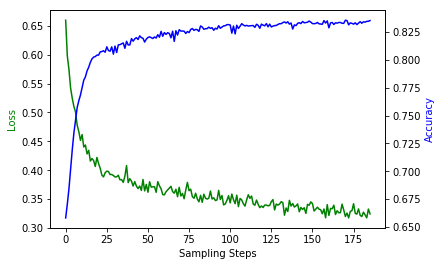

In [7]:
# Get loss criterion of the net and the target type it requires
# We let the net class decide on its loss criterion and the type of the targets that this loss criterion requires
# Not all nets are compatible with all available criterions

criterion, target_type = net.get_criterion()

# cut validation data from training data.
# convert numpy arrays to torch tensors
x_val_torch = torch.from_numpy(x_train[0:val_prop, :])
y_val_torch = torch.from_numpy(y_train[0:val_prop]).float()
x_train_torch = torch.from_numpy(x_train[val_prop + 1:, :])
y_train_torch = torch.from_numpy(y_train[val_prop + 1:]).float()

# create batch loaders
train_set = utils.TensorDataset(x_train_torch, y_train_torch)
train_loader = utils.DataLoader(train_set, batch_size, shuffle=False)
val_set = utils.TensorDataset(x_val_torch, y_val_torch)
val_loader = utils.DataLoader(val_set, batch_size, shuffle=False)

# Lists and counters
steps = 0
running_loss = 0
loss_list = []
val_list = []
start = time.time()

# Iterate through all epochs, predict and backpropagate, update weights
for e in range(epochs):
    for tweets, labels in iter(train_loader):
        steps += 1
        # converting to Variable is necessary in order to compute the gradient later
        inputs = Variable(tweets)
        targets = Variable(labels.to(target_type))
        # set gradient to zero
        optimizer.zero_grad()
        # forward inputs through the net
        outputs = net.forward(inputs.long())
        # compute loss and gradient
        loss = criterion(outputs, targets)
        loss.backward()
        # update weights
        optimizer.step()
        running_loss += loss.item()
        
        # print loss and accuracy at fixed steps
        if steps % print_every == 0:
            stop = time.time()
            accuracy = 0
            n = 0
            # net needs to be set in eval mode to not apply dropout during prediction
            net.eval()
            for tweets, labels in iter(val_loader):
                predictions = net.predict(tweets.long())
                accuracy += sum(predictions.data.numpy() == labels.data.numpy())
                # we cannot use fixed increments of the counter as the last batch can be smaller.
                n += labels.data.numpy().size
            net.train()
            
            print("Epoch {} / {}\t".format(e+1, epochs),
                  "Loss {:.4f}\t".format(running_loss / print_every),
                  "Validation accuracy {:.4f}\t".format(accuracy / n),
                  "{:.4f} s/batch".format((stop - start)/print_every))
            
            # append accuracy and loss to the list for plotting
            loss_list.append(running_loss / print_every)
            val_list.append(accuracy / n)
            
            running_loss = 0
            start = time.time()
            
# plot loss and accuracy
training_stats = np.column_stack((np.asarray(loss_list), np.asarray(val_list)))
plot_val_acc(training_stats)

#save net and stats
torch.save(net, net_filename)
np.save(stats_filename, training_stats)

### IV) Evaluate model

#### Test on local validation set

In [8]:
# Net needs to be set to eval mode, so it will not use dropout when predicting
net.eval()
accuracy = 0
n = 0
for tweets, labels in iter(val_loader):
    predictions = net.predict(tweets.long())
    accuracy += sum(predictions.data.numpy() == labels.data.numpy())
    n += labels.data.numpy().size
            
print("Accuracy on validation set: {:.4f}".format(accuracy / n))

Accuracy on validation set: 0.8353


#### Create submission file for challenge

In [9]:
# Compute preditions
net.eval()
# create a dataloader to iterate over the test data
test_loader = utils.DataLoader(torch.from_numpy(x_test), batch_size, shuffle = False)
submission_labels = np.zeros((0))
for tweets in iter(test_loader):
    predictions = net.predict(tweets.long())
    #conversion from (0, 1) to (-1, 1)
    labels = predictions.data.numpy() * 2 - 1
    submission_labels = np.concatenate((submission_labels, labels), axis=0)
    
# we need to add IDs to meet the submission interface requirements
ids = np.arange(len(submission_labels)) + 1
create_csv_submission(ids, submission_labels, submission_filename)